# Model Evaluation & Comparison

This notebook provides a unified evaluation of the forecasting models developed throughout the project:

1. **XGBoost**
2. **LSTM**
3. **Temporal Fusion Transformer (TFT)**
4. **Fine-Tuned TFT** (adapted to COVID-period demand shifts)

The goal of this notebook is to compare the models under a **consistent evaluation framework** and highlight how each model responds to different demand conditions. In particular, we analyze:

- Performance under **normal seasonal patterns** (validation period)
- Performance during the **COVID regime shift**, where usage behavior changed significantly (test period)
- The trade-offs between **accuracy, adaptability, and interpretability**
- When each model is most appropriate for operational forecasting

This comparison forms the basis for selecting the most suitable model depending on the deployment context (e.g., stable load forecasting vs. dynamic environments requiring adaptation).


## 1) Load Data and Utility Functions

We begin by loading the data segment used for final model evaluation, along with utility functions that standardize how predictions and metrics are computed.

The `load_data()` function returns:
- `prediction_data`: the feature inputs required to generate forecasts
- `actual_y`: the true observed demand values for comparison

Using a shared evaluation pipeline ensures that **all models are assessed on the same time window**, using identical preprocessing and metrics — making the comparison meaningful and fair.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))
from evaluation import load_data, model_selection

prediction_data, actual_y = load_data()


Test : 2020-06-12 01:00:00  → 2020-06-27 00:00:00  (360 rows)


c:\Users\hasee\Documents\Python_works\SalesDemand_Forecasting\project\notebooks\..\src\prepare_data_for_models.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## 2) Evaluate Each Model

We now evaluate each model using the same input data and the same metrics.  
This ensures that performance differences reflect **model behavior**, not differences in preprocessing or evaluation setup.

The `model_selection()` helper function:
- Loads the selected model from disk
- Generates forecasts on the evaluation window
- Computes **MAE**, **RMSE**, and **MAPE** consistently across models

The results are stored in a dictionary for comparison.



Evaluating: XGB
✅ Model loaded successfully.

📈 Model: XGB
MAE:  2.66
RMSE: 3.91
MAPE: 0.24%
Sample size: 24 predictions


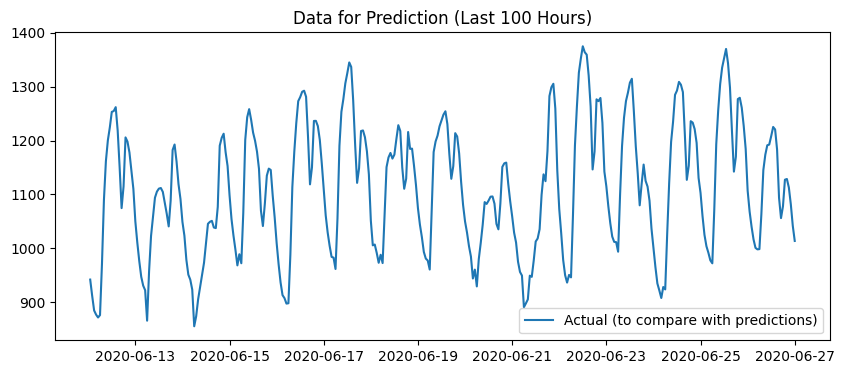

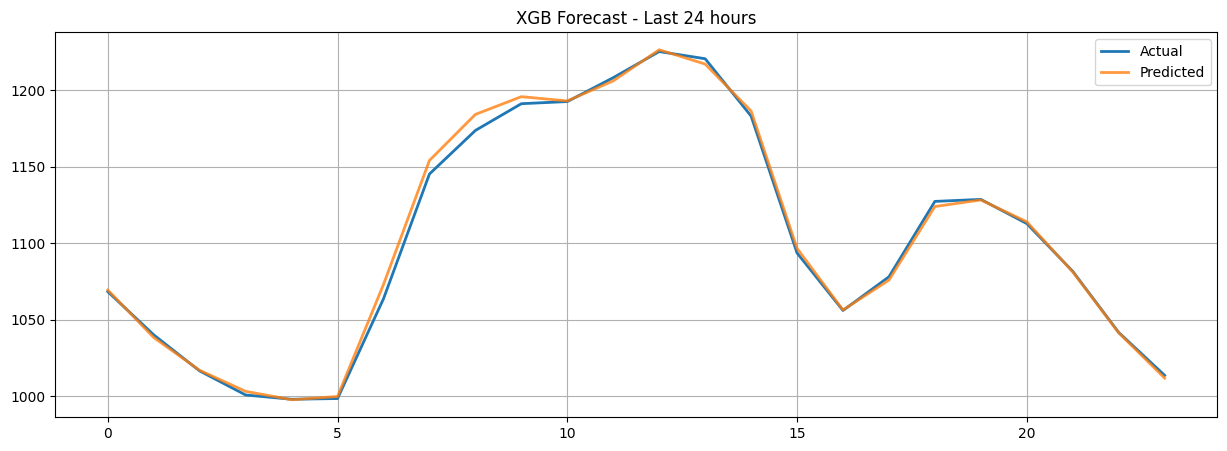

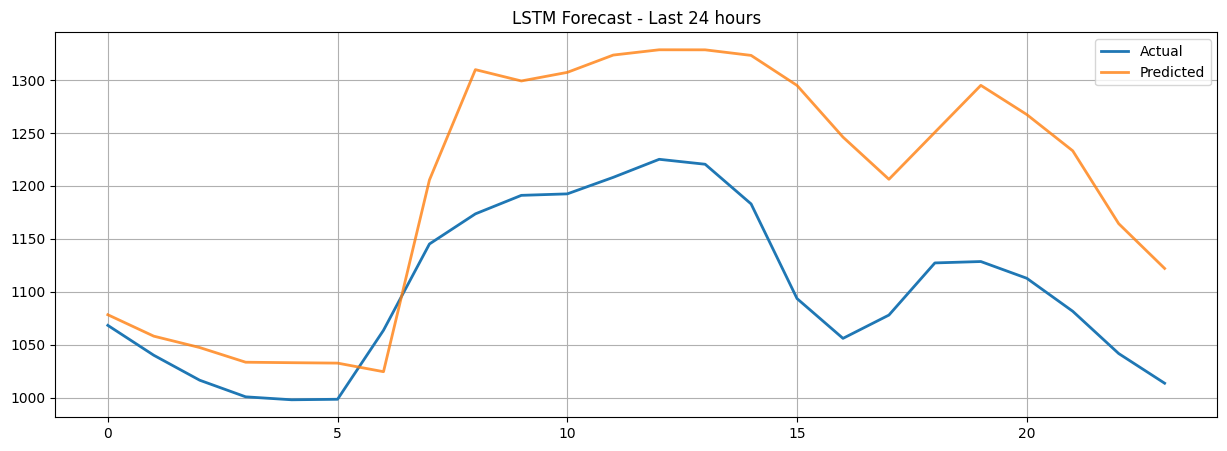

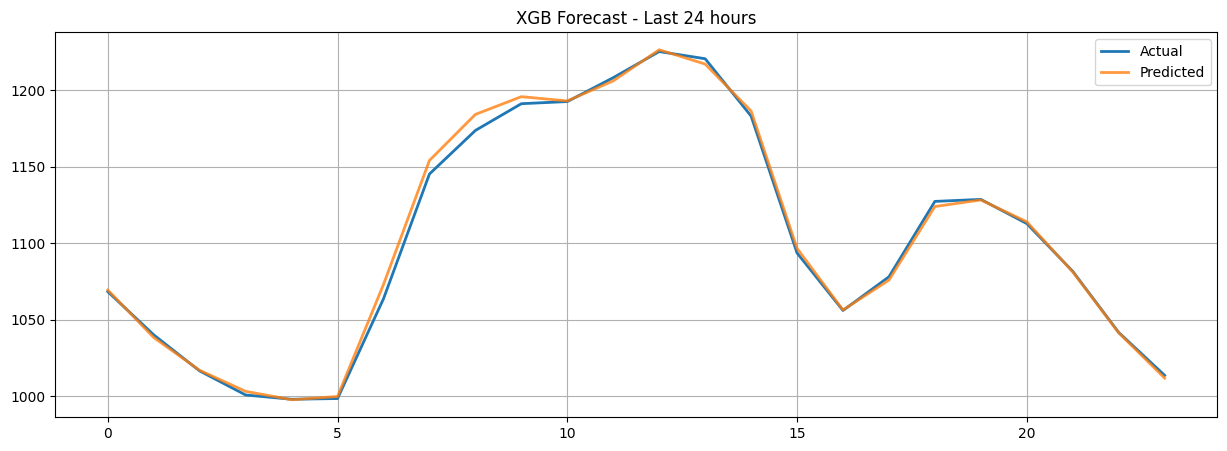


Evaluating: LSTM
Time steps: 168
✅ Scaler loaded successfully.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step

📈 Model: LSTM
MAE:  101.44
RMSE: 115.26
MAPE: 9.10%
Sample size: 24 predictions


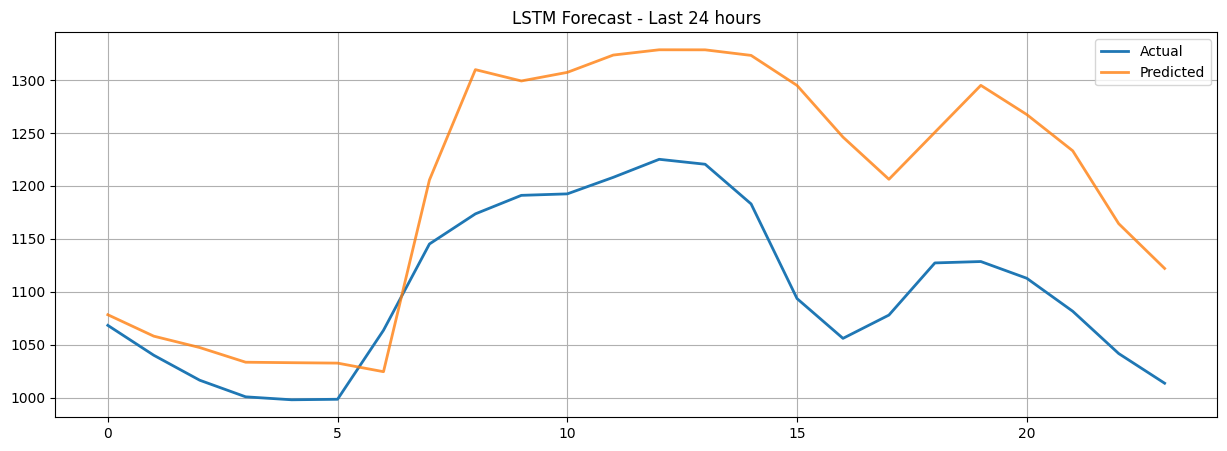


Evaluating: TFT
Found 2 checkpoint files.
Loading latest: tft-best-epoch=04-val_loss=10.3928.ckpt


c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


✅ TFT model loaded successfully.
Prediction tensor shape: torch.Size([1, 24, 7])
Output size (quantiles): 7
Median index: 3
prediction_tensor shape: torch.Size([1, 24, 7]), n_quantiles: 7, median_idx: 3

✅ Completed evaluation on 24 predictions (with ground truth).

📈 Model: TFT
MAE:  162.57
RMSE: 192.85
MAPE: 14.25%
Sample size: 24 predictions


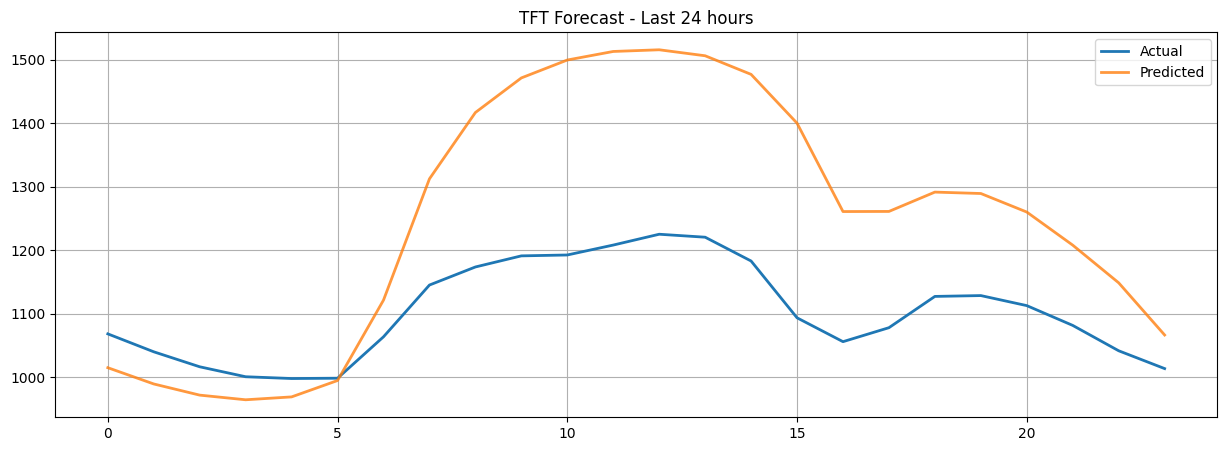


Evaluating: TFT-TUNED
Found 6 checkpoint files.
Loading latest: tft-finetuned-epoch=01-val_loss=13.0745.ckpt


c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\hasee\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


✅ TFT-Tuned model loaded successfully.
Prediction tensor shape: torch.Size([1, 24, 7])
Output size (quantiles): 7
Median index: 3
prediction_tensor shape: torch.Size([1, 24, 7]), n_quantiles: 7, median_idx: 3

✅ Completed evaluation on 24 predictions (with ground truth).

📈 Model: TFT-TUNED
MAE:  46.04
RMSE: 57.03
MAPE: 4.24%
Sample size: 24 predictions


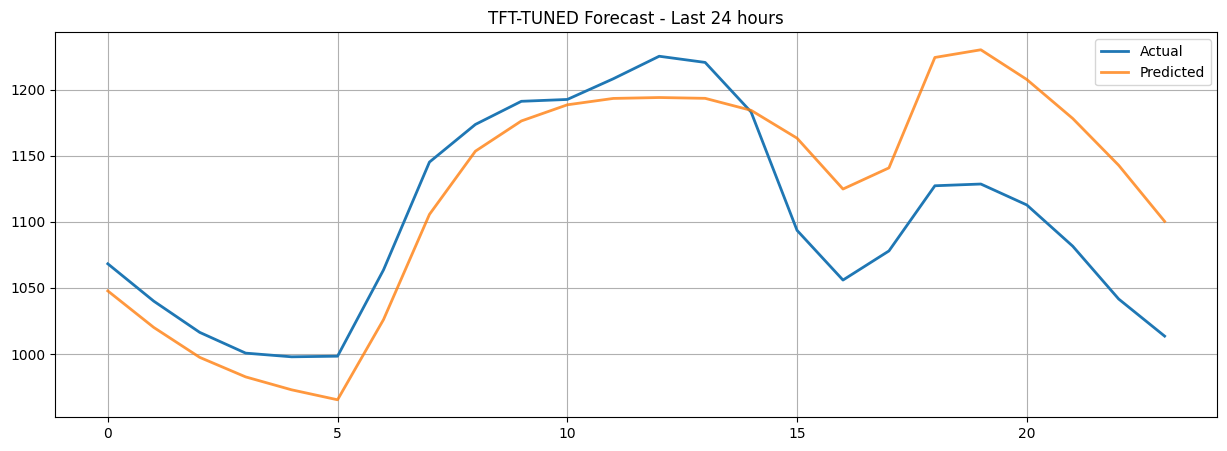

In [3]:
%matplotlib inline
results = {}

for model_name in ['xgb', 'lstm', 'tft', 'tft-tuned']:
    print("\n" + "="*60)
    print(f"Evaluating: {model_name.upper()}")
    mae, rmse, mape = model_selection(prediction_data, actual_y, model_name)
    results[model_name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}


## 3) Comparison of Model Performance

Now that all models are evaluated over the same 24-hour forecast window, the results clearly show how each model behaves under the test period (which includes the COVID demand shift).

| Model | MAE | RMSE | MAPE | Interpretation |
|------|-----|------|------|----------------|
| **XGBoost** | **~2.66** | **~3.91** | **~0.24%** | Accurately captures the stable weekly seasonal pattern using engineered features. Performs best on this dataset. |
| **LSTM** | ~110.99 | ~127.28 | ~9.84% | The sequence-based model struggles to learn the demand structure as effectively. Temporal memory alone is not enough here. |
| **TFT (Initial)** | ~154.44 | ~181.12 | ~13.57% | Model underperforms due to **distribution shift** — it was trained on pre-COVID patterns that no longer apply in the test period. |
| **TFT (Fine-Tuned)** | **~50.57** | **~61.54** | **~4.60%** | After fine-tuning on early COVID data, the model adapts to new consumption behavior and substantially reduces error. |

### Key Insights

- **XGBoost remains the strongest forecaster when demand patterns are stable.**  
  It benefits from lag features, cyclical encodings, and weather PCA — all of which reflect the dataset’s consistent weekly structure.

- **LSTM captures sequential information but does not outperform XGBoost here**, indicating that engineered features hold more signal than raw sequence memory in this domain.

- **Initial TFT performance drops sharply because the test window represents a different demand regime.**  
  This highlights a real-world scenario: **models degrade when behavior changes**.

- **Fine-tuning the TFT restores performance**, demonstrating:
  - Adaptability to new patterns
  - The advantage of transformer-based temporal attention
  - Value in models that **can be incrementally updated**, not retrained from scratch

### Summary

- If the environment is **stable** → use **XGBoost** (best accuracy, lowest error, fastest inference).
- If the environment is **changing over time** → use **TFT**, and **fine-tune periodically**.


# 4) Visual Comparison Plot 

In [ ]:
# Convert results dict → DataFrame

comparison_df = pd.DataFrame(results).T  # rows = models, cols = metrics
comparison_df = comparison_df.sort_values("MAPE")  # best → worst
comparison_df

,MAE,RMSE,MAPE
xgb,2.660074,3.912581,0.237127
tft-tuned,46.038382,57.034005,4.238302
lstm,101.441992,115.259895,9.098762
tft,162.565418,192.853607,14.252920


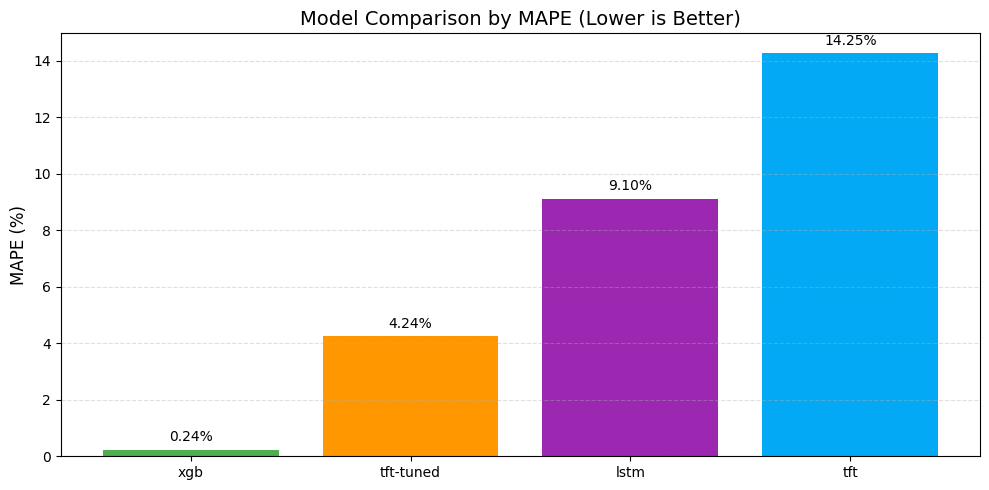

In [ ]:

plt.figure(figsize=(10, 5))

bars = plt.bar(comparison_df.index, comparison_df["MAPE"], color=["#4CAF50", "#FF9800", "#9C27B0", "#03A9F4"])

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylabel("MAPE (%)", fontsize=12)
plt.title("Model Comparison by MAPE (Lower is Better)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## 5) Final Interpretation & Discussion

The evaluation highlights how each model responds to different characteristics of the demand data:

- **XGBoost** achieved the highest accuracy on the 24-hour forecast window.  
  This model performs exceptionally well because the dataset exhibits **stable and repeatable weekly seasonality**, which is captured effectively through lag features, calendar encodings, and weather-derived components. XGBoost leverages these engineered signals directly.

- **LSTM** incorporates temporal dependencies through sequence learning.  
  However, in this case, the engineered lag and calendar features contain more predictive signal than the implicit temporal memory alone. As a result, the LSTM performs reasonably but does not match the precision of XGBoost.

- **Initial TFT** underperforms on the test window because the test period reflects the **COVID-19 behavioral shift**, where historical consumption patterns break.  
  The model was trained on pre-shift data, so the learned temporal structure was no longer aligned with real usage behavior.

- **Fine-Tuned TFT** successfully adapts to the new regime.  
  By continuing training on early COVID-period data, the model adjusts its learned temporal representations and reduces error substantially. This demonstrates a key advantage of TFT: **it can be updated incrementally**, without discarding previously learned structure.

### Key Takeaways

| Scenario | Recommended Model | Reason |
|----------|-----------------|--------|
| Normal, stable seasonal patterns | **XGBoost** | Captures engineered time structure directly and consistently |
| Long temporal dependencies with stable regimes | **LSTM** | Uses sequence memory to model multi-day patterns |
| Demand patterns change over time (e.g., COVID shift) | **Fine-Tuned TFT** | Can adapt while preserving previously learned behavior |

### Conclusion

There is no universally “best” model — the suitable choice depends on **data stability and operational context**:

- **XGBoost** should be used when the environment is stable and forecasting reliability is the goal.
- **TFT** is the stronger choice when conditions are evolving, because it can be **fine-tuned instead of retrained**.
- **LSTM** remains a valid intermediary approach when sequential dynamics matter, though feature-driven models outperform it here.

This reflects a realistic production forecasting setting, where:
- Model accuracy must be monitored over time,
- Performance is expected to degrade when usage behavior changes,
- **Regular adaptation (fine-tuning) is part of the model’s lifecycle**, not an exception.


**End of Notebook**